In [1]:
# IMPORT REQUIRED LIBRARIES
try:
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd 
    import warnings
    import tensorflow as tf
    from sklearn.preprocessing import MinMaxScaler
    plt.style.use("ggplot")
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout
    print("---- Libraries Loaded ----")
except:
    print("---- Libraries Not Loaded ----")

DeprecationWarning("ignore")
warnings.filterwarnings("ignore")


---- Libraries Loaded ----


In [2]:
os.listdir()


['.git',
 'bitcoinprice.pkl',
 'bitcoin_model.json',
 'bitcoin_model_weights.h5',
 'BTC-INR.csv',
 'BTC-USD.csv',
 'BTC_predictions.png',
 'BTC_validation.png',
 'main.ipynb',
 'main.py',
 'README.md']

In [3]:
# READING DATASET
df = pd.read_csv("BTC-USD.csv")


In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,2.105680e+07
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07
...,...,...,...,...,...,...,...
2421,2021-05-04,57214.179688,57214.179688,53191.425781,53333.539063,53333.539063,6.856471e+10
2422,2021-05-05,53252.164063,57911.363281,52969.054688,57424.007813,57424.007813,6.924132e+10
2423,2021-05-06,57441.308594,58363.316406,55382.507813,56396.515625,56396.515625,6.952329e+10
2424,2021-05-07,56413.953125,58606.632813,55321.847656,57356.402344,57356.402344,6.843402e+10


In [5]:
df.describe()


,Open,High,Low,Close,Adj Close,Volume
count,2422.000000,2422.000000,2422.000000,2422.000000,2422.000000,2.422000e+03
mean,7222.063690,7424.075913,7012.698308,7244.783866,7244.783866,1.206688e+10
std,11075.435681,11416.741157,10711.291406,11120.735247,11120.735247,1.902440e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,457.029487,462.521988,453.033508,457.392510,457.392510,6.819998e+07
50%,4167.494873,4309.098632,4047.088012,4168.899902,4168.899902,3.899710e+09
75%,9083.258789,9274.412110,8843.286865,9111.083252,9111.083252,1.808117e+10
max,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2426 entries, 0 to 2425
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2426 non-null   object 
 1   Open       2422 non-null   float64
 2   High       2422 non-null   float64
 3   Low        2422 non-null   float64
 4   Close      2422 non-null   float64
 5   Adj Close  2422 non-null   float64
 6   Volume     2422 non-null   float64
dtypes: float64(6), object(1)
memory usage: 132.8+ KB


In [7]:
df.isnull().sum()


Date         0
Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

In [8]:
# REMOVING NULL DATA
df.dropna(axis=0,how='any',inplace=True)


In [9]:
print(df.isnull().sum())
df_index = df.index.ravel()
print(df.index)
print(df.columns)
df.shape


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425],
           dtype='int64', length=2422)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


(2422, 7)

In [10]:
# TAKING ONLY 1 COLUMN (i.e, Close)
df = df.set_index("Date")[['Close']]
df = df.set_index(pd.to_datetime(df.index))

# NORMALISING/SCALING DATA
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


In [11]:
print(df.columns)


Index(['Close'], dtype='object')


In [12]:
print(df.index)


DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2021-04-29', '2021-04-30', '2021-05-01', '2021-05-02',
               '2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06',
               '2021-05-07', '2021-05-08'],
              dtype='datetime64[ns]', name='Date', length=2422, freq=None)


In [13]:
def visualize_training_results(results):
    
    # Plots the loss and accuracy for the training and testing data
    
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def split_sequence(seq, n_steps_in, n_steps_out):
    
    # Splits the univariate time sequence
    
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)


def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Create a specified number of hidden layers for an RNN
    Optional: Adds regularization option, dropout layer to prevent potential overfitting if necessary
    """
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass
        

In [14]:
# How many periods looking back to train
n_per_in  = 30
# How many periods ahead to predict
n_per_out = 10
# Features (in this case it's 1 because there is only one feature: price)
n_features = 1
# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)
# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))


In [16]:
# Building the model
model = Sequential()
# Activation
activ = "softsign"
# Input layer
model.add(LSTM(30, activation='relu', return_sequences=True, input_shape=(n_per_in, n_features)))
# Hidden layers
layer_maker(n_layers=6, n_nodes=12, activation=activ)
# Final Hidden layer
model.add(LSTM(10, activation=activ))
# Output layer
model.add(Dense(n_per_out))
model.compile(optimizer = 'adam', loss = tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
# Model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 12)            2064      
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 12)            1200      
_________________________________________________________________
lstm_12 (LSTM)               (None, 30, 12)            1200      
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 12)            1200      
_________________________________________________________________
lstm_14 (LSTM)               (None, 30, 12)            1200      
_________________________________________________________________
lstm_15 (LSTM)               (None, 30, 12)           

In [18]:
with tf.device('/GPU:0'):
    res = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1)


Epoch 1/100
67/67 [==============================] - 66s 983ms/step - loss: 0.0020 - accuracy: 0.0942 - val_loss: 0.2161 - val_accuracy: 0.0711
Epoch 2/100
67/67 [==============================] - 58s 862ms/step - loss: 5.8203e-04 - accuracy: 0.1115 - val_loss: 0.1995 - val_accuracy: 0.0879
Epoch 3/100
67/67 [==============================] - 58s 873ms/step - loss: 5.6010e-04 - accuracy: 0.1049 - val_loss: 0.1962 - val_accuracy: 0.0628
Epoch 4/100
67/67 [==============================] - 57s 855ms/step - loss: 5.5357e-04 - accuracy: 0.0975 - val_loss: 0.1883 - val_accuracy: 0.0921
Epoch 5/100
67/67 [==============================] - 58s 863ms/step - loss: 5.3956e-04 - accuracy: 0.0910 - val_loss: 0.1851 - val_accuracy: 0.0711
Epoch 6/100
67/67 [==============================] - 58s 860ms/step - loss: 5.1589e-04 - accuracy: 0.1152 - val_loss: 0.1799 - val_accuracy: 0.0711
Epoch 7/100
67/67 [==============================] - 57s 856ms/step - loss: 4.9767e-04 - accuracy: 0.1040 - val_loss

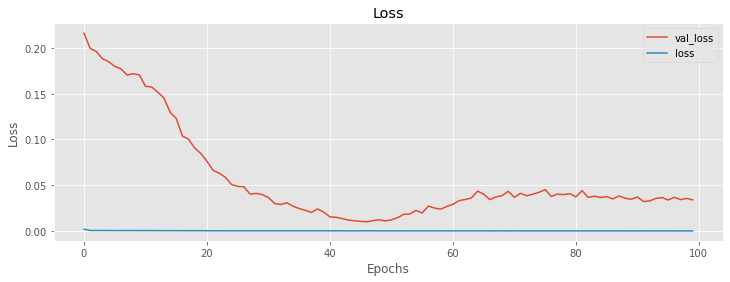

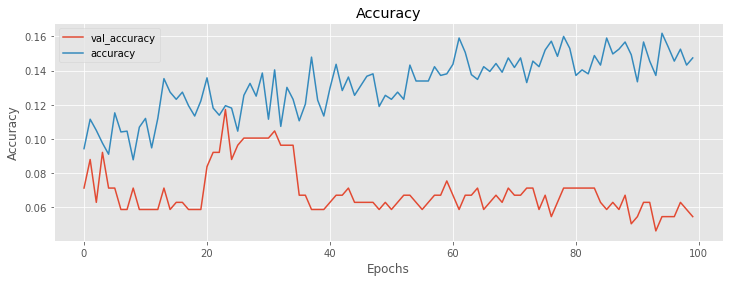

In [19]:
visualize_training_results(res)


Predicted Prices:
 [[69844.30536067598], [70052.40028051265], [54256.6929126072], [72869.38164818194], [61867.98012874016], [68331.14442685965], [60926.6197372763], [67206.06851567567], [68159.94887465563], [66132.38599541703]]

Actual Prices:
 [[53555.109375], [57750.17578099999], [57828.05078099999], [56631.078125], [57200.29296900001], [53333.539063], [57424.007813], [56396.515625], [57356.40234400001], [58211.10546900001]]


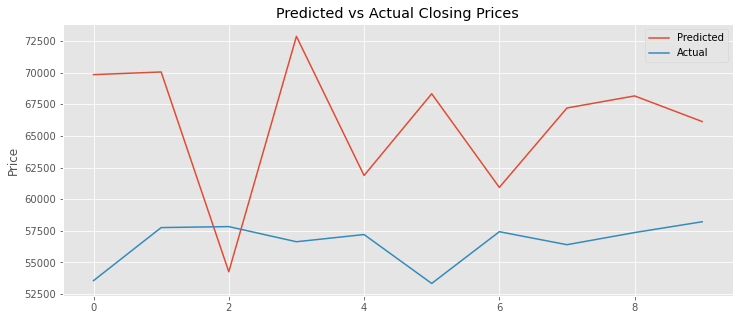

In [20]:
plt.figure(figsize=(12,5))
# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]
# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()



                   Close
2021-05-08  69876.554563
2021-05-09  70080.678724
2021-05-10  54272.674083
2021-05-11  72901.819574
2021-05-12  61888.547299
2021-05-13  68356.992102
2021-05-14  60942.940611
2021-05-15  67233.048536
2021-05-16  68184.475480
2021-05-17  66155.297121


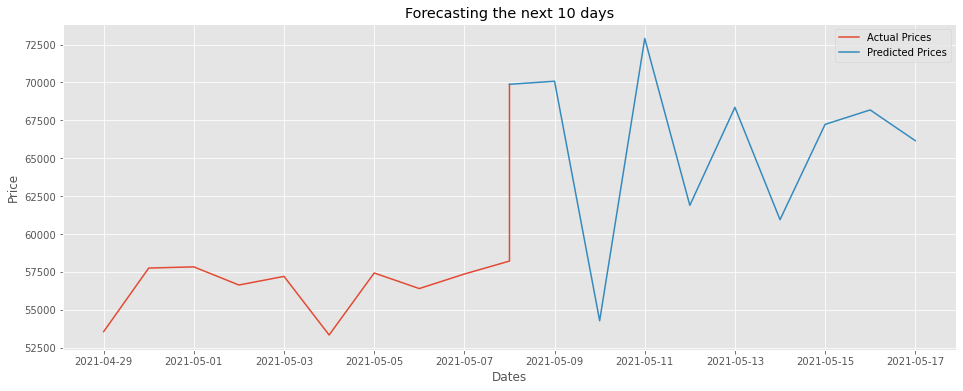

In [21]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]
# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()
# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)
# Printing the predicted prices
print(preds)
# Number of periods back to visualize the actual values
pers = 10
# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))
# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()


In [22]:
import pickle
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Pkl_Filename = "bitcoinprice.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(sc, file)
    

In [23]:
from keras.models import model_from_json

bitcoin_model_json = model.to_json()  
with open("bitcoin_model.json", "w") as json_file:  
    json_file.write(bitcoin_model_json)  
model.save_weights("bitcoin_model_weights.h5")


In [30]:
with open("bitcoinprice.pkl", 'rb') as f:
    bmodel = pickle.load(f)
    